#### Проект учебного спринта "Статистический анализ данных"
## Определение перспективного тарифа для телеком-компании

#### Исполнитель. Варивода С. П.

### Описание проекта

У оператора связи "Мегалайн" есть два тарифных плана: "Смарт" и "Ультра".
Необходимо сравнить данные по использованию этих тарифов.


<b>Тариф «Смарт»</b><BR>
Ежемесячная плата: 550 рублей<BR>
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика<BR>
Стоимость услуг сверх тарифного пакета:<BR>
минута разговора: 3 рубля<BR>
сообщение: 3 рубля<BR>
1 Гб интернет-трафика: 200 рублей<BR>

<b>Тариф «Ультра»</b><br>
Ежемесячная плата: 1950 рублей<br>
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика<br>
Стоимость услуг сверх тарифного пакета:<br>
минута разговора: 1 рубль<br>
сообщение: 1 рубль<br>
1 Гб интернет-трафика: 150 рублей<br>

### Цель проекта

Определить, какой из двух тарифов приносит больше денег.

План проекта:
- Загрузка данных из предоставленных таблиц
- Проверка общей информации о предоставленных данных
- Проверка данных на наличие ошибок, корректности форматов столцов, исправление ошибок и форматов при необходимости
- Формирование таблиц-метрик
- Заполнение пропусков
- Анализ данных на основе выборки: построение гистограмм, оценка потребностей пользователей по потреблению интернет-трафика, сообщений и звонков
- Проверка гипотезы о неравенстве выручки двух тарифов
- Проверка гипотезы о различии выручки в Москве и других регионах
- Общий вывод

### Шаг 1. Откройте файл с данными и изучите общую информацию

Импорт модулей

In [126]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
import platform
from scipy import stats as st

Загрузка данных

In [127]:
host = platform.node()

# На машинах исполнителя проекта файл с данными доступен через символический путь, 
# ссылающийса на папку на яндекс.диске, где расположен загружаемый файл. 
# В случае если хостом где выполняется анализ является какая-либо другая машина, 
# используем путь по умолчанию.
try:    
    if host in ['22varivoda','Gover-pc','MSI']:
        filepath    = 'C:/_YDsymlink/Python/datascience/Projects/09 - Статистический анализ данных/'
    else:
        filepath    = '/datasets/'
except:
    print("Не удалось подгрузить данные")
    
pd.reset_option('^display.',silent=True)
pd.set_option('display.float_format', str)


In [128]:
d_calls     = pd.read_csv(filepath+"calls.csv")
d_internet  = pd.read_csv(filepath+"internet.csv")
d_messages  = pd.read_csv(filepath+"messages.csv")
d_tariffs   = pd.read_csv(filepath+"tariffs.csv")
d_users     = pd.read_csv(filepath+"users.csv")

#### 1.1. Проверка базовой информации о таблицах

#### 1.1.1 <code>calls</code> - Звонки 

In [133]:
d_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [134]:
d_calls.sample(1)

,id,call_date,duration,user_id
150365,1377_1212,2018-08-18,4.56,1377


Необходимо преобразовать тип столбца call_date в datetime

Судя по разным столбцам, в компании принято столбцы id делить на две части. NN_MM, <BR>
Где NN - идентификатор текущей таблицы, <BR>
А MM - идентификатор пользователя <code>users.user_id</code>
На шаге 2 попытаемся разделить этот столбец на два.

#### 1.1.2 <code>internet</code> - Информация об интернет-сессиях 

In [135]:
d_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [136]:
d_internet.sample(1)

,Unnamed: 0,id,mb_used,session_date,user_id
1056,1056,1004_276,624.94,2018-05-30,1004


Необходимо разобраться с безымянным столбцом, дать ему имя, либо удалить.<BR>
Столбец session_date необходимо привести к формату datetime

Аналогично предыдущей таблице нужно попытаться разделить столбец идентификатора на два

#### 1.1.3 <code>messages</code> - Информация о сообщениях 

In [137]:
d_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [138]:
d_messages.sample(1)

,id,message_date,user_id
104369,1424_222,2018-10-27,1424


Столбец message_date необходимо привести к формату datetime и тоже разделить идентификаторы (<code>id</code>)

#### 1.1.4 <code>tariffs</code> - Информация о тарифах 

In [139]:
d_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [140]:
d_tariffs.sample(1)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart


Преобразований не требуется

#### 1.1.5 <code>users</code> - Пользователи 

In [141]:
d_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [142]:
d_users.sample(1)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
490,1490,30,NaN,Москва,Радомир,Алесин,2018-04-03,smart


Столбец reg_date необходимо привести к формату datetime.<BR>
Возможно что столбец churn_date тоже, но необходима оценка, является ли null тоже полезным значением или нет.

### Шаг 2. Подготовка данных

Подготовим функцию, которая будет вытаскивать user_id и id текущей таблицы из столбцов с идентификаторами

In [143]:
def get_id(value, id_part='all'):
    try:
        result = re.match(r"(\d+)_(\d+)",value)
        user_id  = result.group(1)
        table_id = result.group(2)
    except:
        print(f"Возникла проблем с регулярным выражением в строке {value}")
    
    if id_part == 'user_id':
        # Возвращаем user_id (часть идентификатора до символа _ )
        return user_id
    elif id_part == 'table_id':
        # Возвращаем table_id (то что после символа _), то есть идентификатор текущей таблицы
        return table_id
    else:
        # Если не указано что возвращать - возвращаем turple-пару user_id, table_id
        return (user_id,table_id)
        

#### 2.1 <code>calls</code> - Звонки 

In [144]:
d_calls.sample(1)

,id,call_date,duration,user_id
118606,1307_80,2018-06-08,0.6,1307


In [145]:
# Меняем формат столбца даты call_date на datetime
d_calls['call_date'] = pd.to_datetime( d_calls['call_date'], format='%Y-%m-%d' )

In [146]:
# Проверка на пустые (нулевые) значения
d_calls.loc[ d_calls['user_id']==0 ]

,id,call_date,duration,user_id


In [147]:
# "Распаковываем" столбец с идентификаторами
d_calls['user_id'] = d_calls['id'].apply(get_id,args=('user_id', )).astype('int')
d_calls['call_id'] = d_calls['id'].apply(get_id,args=('table_id',)).astype('int')

In [148]:
d_calls.sample(3)

,id,call_date,duration,user_id,call_id
90797,1227_217,2018-06-15,5.2,1227,217
21639,1057_88,2018-12-24,0.0,1057,88
42234,1104_136,2018-09-15,11.82,1104,136


#### 2.2 <code>internet</code> - Информация об интернет-сессиях

In [149]:
d_internet.sample(1)

,Unnamed: 0,id,mb_used,session_date,user_id
78208,78208,1263_279,0.0,2018-07-06,1263


In [150]:
# Проверка на пустые (нулевые) значения
d_internet.loc[(d_internet['user_id'] == 0)
              |(d_internet['id'] == 0)
              |(d_internet['session_date'] == 0)
              |(d_internet['session_date'] == '1900-01-01')
              ]

,Unnamed: 0,id,mb_used,session_date,user_id


In [151]:
# Меняем формат столбца даты session_date на datetime
d_internet['session_date'] = pd.to_datetime( d_internet['session_date'], format='%Y-%m-%d' )

Судя по значениям, столбец "Unnamed: 0" представляет из себя ничто иное как копию индекса. Проверим начальные и последние значения в нём. И если они соответствуют индексам то избавимся от этого столбца. Если будет нужно мы сможем его воссоздать по индексам.

In [152]:
d_internet.head(2)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000


In [153]:
d_internet.tail(2)

,Unnamed: 0,id,mb_used,session_date,user_id
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [154]:
d_internet.sample(1)

,Unnamed: 0,id,mb_used,session_date,user_id
106840,106840,1362_70,218.97,2018-09-18,1362


In [155]:
# Удаляем этот столбец
d_internet = d_internet.drop(columns=d_internet.columns[0])
d_internet.sample(1)

,id,mb_used,session_date,user_id
72452,1244_284,191.0,2018-06-11,1244


"Распаковка" идентификаторов

In [156]:
# "Распаковываем" столбец с идентификаторами
d_internet['user_id'] = d_internet['id'].apply(get_id, args=('user_id', )).astype('int')
d_internet['session_id'] = d_internet['id'].apply(get_id, args=('table_id',)).astype('int')

Проверка того, как распаковались идентификаторы:

In [157]:
d_internet.sample(5)

,id,mb_used,session_date,user_id,session_id
89970,1304_9,330.27,2018-11-08,1304,9
8942,1032_22,0.0,2018-03-04,1032,22
80611,1272_3,454.88,2018-12-03,1272,3
2047,1007_171,0.0,2018-06-27,1007,171
2658,1009_300,0.0,2018-08-13,1009,300


#### 2.3 <code>messages</code> - Информация о сообщениях 

In [158]:
# Проверка на пустые (нулевые) значения
d_messages.loc[(d_messages['id'] == 0)
              |(d_messages['message_date'] == 0)
              |(d_messages['message_date'] == '1900-01-01')
              ]

,id,message_date,user_id


In [159]:
d_messages.sample(1)

,id,message_date,user_id
45715,1197_45,2018-12-11,1197


In [160]:
d_messages['message_date'] = pd.to_datetime( d_messages['message_date'], format='%Y-%m-%d' )

"Распаковка" идентификаторов

In [161]:
# "Распаковываем" столбец с идентификаторами
d_messages['user_id']    = d_messages['id'].apply(get_id, args=('user_id', )).astype('int')
d_messages['message_id'] = d_messages['id'].apply(get_id, args=('table_id',)).astype('int')

Проверка того, как распаковались идентификаторы:

In [162]:
d_messages.sample(5)

,id,message_date,user_id,message_id
118308,1481_79,2018-04-24,1481,79
73992,1312_71,2018-10-06,1312,71
18711,1082_152,2018-12-10,1082,152
66753,1284_341,2018-07-16,1284,341
92841,1382_302,2018-12-05,1382,302


#### 2.4 <code>users</code> - Пользователи 

In [163]:
d_users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
241,1241,71,NaN,Новосибирск,Инна,Андреенко,2018-05-02,smart
300,1300,40,NaN,Москва,Тихон,Азерников,2018-07-26,ultra
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart
327,1327,45,NaN,Новороссийск,Клавдия,Севастьянова,2018-04-09,smart
225,1225,71,NaN,Оренбург,Даниэла,Горбачева,2018-04-26,ultra


In [164]:
d_users['reg_date'] = pd.to_datetime( d_users['reg_date'], format='%Y-%m-%d' )

Проверка столбца возрастов на аномалии

In [165]:
d_users['age'].value_counts().index.sort_values()

Int64Index([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75],
           dtype='int64')

Столбец в порядке

Города - проверка на аномальные значения

In [166]:
d_users['city'].value_counts().head(2)

Москва             99
Санкт-Петербург    39
Name: city, dtype: int64

In [167]:
d_users['city'].value_counts().tail(2)

Химки      1
Иваново    1
Name: city, dtype: int64

In [168]:
d_users['city'].sort_values().head(2)

135    Архангельск
253      Астрахань
Name: city, dtype: object

In [169]:
d_users['city'].sort_values().tail(2)

472    Ярославль
39     Ярославль
Name: city, dtype: object

Города в порядке

Фамилии и имена - проверка на аномалии

In [170]:
d_users['last_name'].value_counts().head(2)

Андреенко    5
Аничкина     3
Name: last_name, dtype: int64

In [171]:
d_users['last_name'].value_counts().tail(2)

Ёркин        1
Карташова    1
Name: last_name, dtype: int64

In [172]:
d_users['last_name'].sort_values().head(2)

416    Ёлчина
465     Ёркин
Name: last_name, dtype: object

In [173]:
d_users['last_name'].sort_values().tail(2)

152    Щербакова
419        Яшина
Name: last_name, dtype: object

In [174]:
d_users['first_name'].value_counts().head(2)

Радим    6
Пётр     5
Name: first_name, dtype: int64

In [175]:
d_users['first_name'].value_counts().tail(2)

Наталья    1
Людмила    1
Name: first_name, dtype: int64

In [176]:
d_users['first_name'].sort_values().head(4)

495    Авксентий
336    Авксентий
82     Авксентий
199        Агата
Name: first_name, dtype: object

Имя "Авксентий" выглядит странно, но нет возможности проверить ошибка это или нет

In [177]:
d_users['first_name'].sort_values().tail(2)

126    Яна
207    Яна
Name: first_name, dtype: object

ФИО в порядке

Проверка, нет ли пользователей, у которых некорректно указан тариф:

In [178]:
len(d_users.loc[ ~ d_users['tariff'].isin(['ultra','smart'])])

0

#### 2.5 Добавление таблиц-метрик

<B>Количество сделанных звонков и израсходованных минут разговора по месяцам </b>

In [179]:
# Добавим столбец месяца в таблицу звонков
d_calls['period'] = pd.DatetimeIndex(d_calls['call_date']).strftime('%Y-%m')

In [180]:
# Округление. Согласно "прожёрливой" политике компании превратим в минуты всё что можно превратить
d_calls['duration'] = np.ceil(d_calls['duration'])

In [181]:
d_calls.sample(3)

,id,call_date,duration,user_id,call_id,period
116757,1300_153,2018-11-07,12.0,1300,153,2018-11
73026,1184_0,2018-09-06,1.0,1184,0,2018-09
39248,1098_76,2018-10-31,0.0,1098,76,2018-10


In [182]:
# Получаем данные по звонкам и собираем их в обобщенную табличку
call_stats = (
    d_calls 
      .pivot_table(
          index =['user_id','period'],
          values=['call_id','duration'],
          aggfunc={ 'call_id':'count',
                   'duration':'sum'}
      ).rename(
          columns={'call_id' :'calls_count',
                   'duration':'total_duration'}
      )
).reset_index() # Сбрасываем индексы для того чтобы перенести их в столбцы

In [183]:
call_stats.sample(3)

,user_id,period,calls_count,total_duration
2157,1344,2018-09,118,901.0
1469,1235,2018-11,88,481.0
1287,1203,2018-12,80,706.0


<b>Количество отправленных сообщений по месяцам</b>

In [184]:
d_messages.sample(3)

,id,message_date,user_id,message_id
10315,1043_22,2018-11-25,1043,22
58489,1257_281,2018-07-01,1257,281
27420,1115_111,2018-10-08,1115,111


In [185]:
# Добавим столбец месяца в таблицу сообщений
d_messages['period'] = pd.DatetimeIndex(d_messages['message_date']).strftime('%Y-%m')

In [186]:
d_messages.sample(3)

,id,message_date,user_id,message_id,period
68842,1294_167,2018-07-21,1294,167,2018-07
16423,1071_54,2018-07-26,1071,54,2018-07
82047,1344_111,2018-06-28,1344,111,2018-06


In [187]:
# Получаем данные по звонкам и собираем их в обобщенную табличку
messages_stats = (
    d_messages
      .pivot_table(
          index =['user_id','period'],
          values=['message_id'],
          aggfunc={ 'message_id':'count' }
      ).rename(
          columns={'message_id' :'messages_count'}
      )
).reset_index() # Сбрасываем индексы для того чтобы перенести их в столбцы

In [188]:
messages_stats.sample(5)

,user_id,period,messages_count
1822,1346,2018-10,49
1923,1369,2018-11,118
1168,1223,2018-12,33
406,1073,2018-12,27
2019,1382,2018-04,80


<b>Объем израсходованного интернет-трафика по месяцам</b>

In [189]:
# Добавим столбец месяца в таблицу интернет-сессий
d_internet['period'] = pd.DatetimeIndex(d_internet['session_date']).strftime('%Y-%m')

In [190]:
# Создаем таблицу статистики по интернет сессиям (использованию трафика в месяц)
internet_stats = (
    d_internet.pivot_table(index=['user_id','period'],values='mb_used',aggfunc='sum')
).reset_index()

In [191]:
# Считаем число гигибайт и округляем в большую сторону до целых
# Также обновим поле с мегабайтами, округлив их в большую сторону до гигибайт
internet_stats['gb_used'] = np.ceil(internet_stats['mb_used']/1024).astype('int')
internet_stats['mb_used'] = np.ceil(internet_stats['mb_used']/1024).astype('int')*1024

In [192]:
internet_stats.sample(2)

,user_id,period,mb_used,gb_used
1165,1180,2018-11,26624,26
249,1039,2018-12,20480,20


<b>Подсчет помесячной выручки</b>

Создадим новую табличку с комбинированными данными по месяцам для каждого пользователя

In [193]:
total_stats = (
    call_stats.merge(messages_stats, on=['user_id','period'], how='outer')
              .merge(internet_stats, on=['user_id','period'], how='outer')
              .merge(d_users, on='user_id', how='outer')
              .merge(d_tariffs, left_on='tariff',right_on='tariff_name', how='left')    
)

In [194]:
total_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   period                 3214 non-null   object        
 2   calls_count            3174 non-null   float64       
 3   total_duration         3174 non-null   float64       
 4   messages_count         2717 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   gb_used                3203 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    object        
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

In [195]:
total_stats.loc[ total_stats['calls_count'].isna(),'calls_count' ] = 0
total_stats.loc[ total_stats['total_duration'].isna(),'total_duration' ] = 0
total_stats.loc[ total_stats['messages_count'].isna(),'messages_count' ] = 0
total_stats.loc[ total_stats['mb_used'].isna(),'mb_used' ] = 0
total_stats.loc[ total_stats['gb_used'].isna(),'gb_used' ] = 0

Похоже что у двух записей не прописался период так как договоры были закрыты до конца месяца

In [196]:
total_stats.loc[ total_stats['period'].isna() ]

,user_id,period,calls_count,total_duration,messages_count,mb_used,gb_used,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
3214,1128,NaN,0.0,0.0,0.0,0.0,0.0,51,2018-12-23,Волжский,...,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,ultra
3215,1371,NaN,0.0,0.0,0.0,0.0,0.0,50,2018-12-30,Омск,...,2018-12-25,smart,50,15360,500,550,200,3,3,smart


Судя по всему эти две записи возникли при объединении таблиц, так как в них нет данных об использовании звонков, смс и интернет-трафика. Получается что их смысл только в абонентской плате. Так как их всего лишь две поправим их вручную. Если бы было много - нужно было бы создавать более красивое решение.

In [197]:
total_stats.loc[ total_stats['period'].isna(),'period' ] = pd.DatetimeIndex(total_stats.loc[ total_stats['period'].isna(),'churn_date']).strftime('%Y-%m')

Столбец с датой закрытия для действующих договоров заполним значением 2099-12-31 (как максимальная дата), хотя по большому счету он для нас уже не важен

In [198]:
total_stats.loc[ total_stats['churn_date'].isna(),'churn_date' ] = '2099-12-31'

null-значения заполнены. Продолжаем

Посчитаем переплаты клиентов за превышения лимитов:

In [199]:
total_stats['time_overpayed'    ] = 0
total_stats['messages_overpayed'] = 0
total_stats['internet_overpayed'] = 0

In [200]:
# Превышение лимитов по длительности звонков
total_stats.loc[  total_stats['total_duration'] > total_stats['minutes_included'],  'time_overpayed'  ] = \
    ((total_stats['total_duration'] - total_stats['minutes_included']) *  total_stats['rub_per_minute'])

In [201]:
# Превышение лимитов по числу смс
total_stats.loc[  total_stats['messages_count'] > total_stats['messages_included'],  'messages_overpayed'  ] = \
    ((total_stats['messages_count'] - total_stats['messages_included']) *  total_stats['rub_per_message'])

In [202]:
# Превышение лимитов по интернет-трафику
total_stats.loc[  total_stats['mb_used'] > total_stats['mb_per_month_included'],  'internet_overpayed'  ] = \
    (((total_stats['mb_used'] - total_stats['mb_per_month_included'])/1024) *  total_stats['rub_per_gb'])

In [203]:
# Общее превышение тарифа
# и общая потраченная клиентом сумма
total_stats.loc[:,'overpay'] =  (total_stats.loc[:,'time_overpayed']) + (total_stats.loc[:,'messages_overpayed']) + (total_stats.loc[:,'internet_overpayed'])
total_stats['period_income'] = total_stats['rub_monthly_fee'] + total_stats['overpay']

In [204]:
total_stats.sample(5)

,user_id,period,calls_count,total_duration,messages_count,mb_used,gb_used,age,churn_date,city,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,time_overpayed,messages_overpayed,internet_overpayed,overpay,period_income
2952,1465,2018-04,40.0,247.0,32.0,9216.0,9.0,41,2099-12-31,Омск,...,550,200,3,3,smart,0.0,0.0,0.0,0.0,550.0
2605,1410,2018-11,69.0,555.0,21.0,26624.0,26.0,25,2099-12-31,Нижний Тагил,...,550,200,3,3,smart,165.0,0.0,2200.0,2365.0,2915.0
2303,1370,2018-08,17.0,123.0,0.0,19456.0,19.0,48,2018-10-27,Новороссийск,...,550,200,3,3,smart,0.0,0.0,800.0,800.0,1350.0
2163,1345,2018-08,31.0,281.0,3.0,24576.0,24.0,31,2099-12-31,Москва,...,550,200,3,3,smart,0.0,0.0,1800.0,1800.0,2350.0
1793,1286,2018-12,95.0,739.0,68.0,35840.0,35.0,19,2099-12-31,Москва,...,550,200,3,3,smart,717.0,54.0,4000.0,4771.0,5321.0


In [205]:
# check
total_stats['period_income'].sum()

4916951.0

### Шаг 3. Анализ данных

Будем проводить анализ на основе выборок размером в 30 записей.



In [206]:
df_ultra_sample = total_stats.loc[ total_stats['tariff'] == 'ultra']
df_smart_sample = total_stats.loc[ total_stats['tariff'] == 'smart']

Считаем среднее, дисперсию, стандартное отклонение

In [207]:
# Тариф Ultra
ultra_time_mean             = df_ultra_sample['total_duration'].mean()
ultra_time_var              = np.var(df_ultra_sample['total_duration'],ddof=1)
ultra_time_std              = np.std(df_ultra_sample['total_duration'],ddof=1)
ultra_messages_mean         = df_ultra_sample['messages_count'].mean()
ultra_messages_var          = np.var(df_ultra_sample['messages_count'],ddof=1)
ultra_messages_std          = np.std(df_ultra_sample['messages_count'],ddof=1)
ultra_internet_traffic_mean = df_ultra_sample['mb_used'].mean()
ultra_internet_traffic_var  = np.var(df_ultra_sample['mb_used'],ddof=1)
ultra_internet_traffic_std  = np.std(df_ultra_sample['mb_used'],ddof=1)

# Тариф Smart 
smart_time_mean             = df_ultra_sample['total_duration'].mean()
smart_time_var              = np.var(df_smart_sample['total_duration'],ddof=1)
smart_time_std              = np.std(df_smart_sample['total_duration'],ddof=1)
smart_messages_mean         = df_ultra_sample['messages_count'].mean()
smart_messages_var          = np.var(df_smart_sample['messages_count'],ddof=1)
smart_messages_std          = np.std(df_smart_sample['messages_count'],ddof=1)
smart_internet_traffic_mean = df_ultra_sample['mb_used'].mean()
smart_internet_traffic_var  = np.var(df_smart_sample['mb_used'],ddof=1)
smart_internet_traffic_std  = np.std(df_smart_sample['mb_used'],ddof=1)

Выведем полученные значения

In [208]:
print( "Тариф Ultra")
print(f"Продолжительность звонка. Среднее: ", round(ultra_time_mean,2))
print(f"Продолжительность звонка. Дисперсия: ", round(ultra_time_var,2))
print(f"Продолжительность звонка. Среднее отклонение: ", round(ultra_time_std,2))
print(f"Число сообщений. Среднее: ", round(ultra_messages_mean,2))
print(f"Число сообщений. Дисперсия: ", round(ultra_messages_var,2))
print(f"Число сообщений. Среднее отклонение: ", round(ultra_messages_std,2))
print(f"Использованный трафик. Среднее: ", round(ultra_internet_traffic_mean,2))
print(f"Использованный трафик. Дисперсия: ", round(ultra_internet_traffic_var,2))
print(f"Использованный трафик. Среднее отклонение: ", round(ultra_internet_traffic_std,2))

print( "Тариф Smart")
print(f"Продолжительность звонка. Среднее: ", round(smart_time_mean,2))
print(f"Продолжительность звонка. Дисперсия: ", round(smart_time_var,2))
print(f"Продолжительность звонка. Среднее отклонение: ", round(smart_time_std,2))
print(f"Число сообщений. Среднее: ", round(smart_messages_mean,2))
print(f"Число сообщений. Дисперсия: ", round(smart_messages_var,2))
print(f"Число сообщений. Среднее отклонение: ", round(smart_messages_std,2))
print(f"Использованный трафик. Среднее: ", round(smart_internet_traffic_mean,2))
print(f"Использованный трафик. Дисперсия: ", round(smart_internet_traffic_var,2))
print(f"Использованный трафик. Среднее отклонение: ", round(smart_internet_traffic_std,2))

Тариф Ultra
Продолжительность звонка. Среднее:  526.09
Продолжительность звонка. Дисперсия:  101052.49
Продолжительность звонка. Среднее отклонение:  317.89
Число сообщений. Среднее:  49.31
Число сообщений. Дисперсия:  2285.42
Число сообщений. Среднее отклонение:  47.81
Использованный трафик. Среднее:  19942.04
Использованный трафик. Дисперсия:  102108804.46
Использованный трафик. Среднее отклонение:  10104.89
Тариф Smart
Продолжительность звонка. Среднее:  526.09
Продолжительность звонка. Дисперсия:  36281.39
Продолжительность звонка. Среднее отклонение:  190.48
Число сообщений. Среднее:  49.31
Число сообщений. Дисперсия:  796.96
Число сообщений. Среднее отклонение:  28.23
Использованный трафик. Среднее:  19942.04
Использованный трафик. Дисперсия:  34742943.65
Использованный трафик. Среднее отклонение:  5894.31


#### 3.1 Анализ показателей выборки тарифа Ultra

Построим гистограммы плотности для длительности звонков, числа сообщений и интернет-трафика. Ширину графика будем брать примерно в 3-4 отклонения в обе стороны от среднего, так как более 99% значений укладываются в 3-х сигменный интервал и масштаб будет вполне подходящий.

##### Длительность звонков

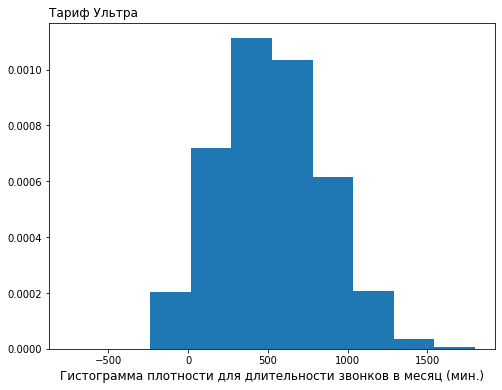

In [209]:
fig, ax = plt.subplots()
ax.hist(
    total_stats.loc[ total_stats['tariff'] == 'ultra']['total_duration'],
    range=(ultra_time_mean-4*ultra_time_std,ultra_time_mean+4*ultra_time_std),
    density=True
)
ax.set_title(
    "Тариф Ультра",
    fontsize=12,
    loc='left'
)
ax.set_xlabel("Гистограмма плотности для длительности звонков в месяц (мин.)", fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

In [210]:
total_stats.loc[ total_stats['tariff'] == 'ultra']['total_duration'].describe()

count               986.0
mean    526.0892494929006
std     317.8875485911392
min                   0.0
25%                 282.5
50%                 518.0
75%                751.75
max                1673.0
Name: total_duration, dtype: float64

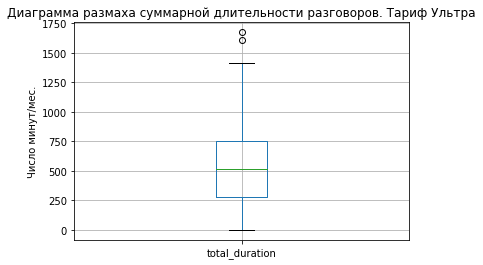

In [211]:
(
    total_stats.loc[ total_stats['tariff'] == 'ultra']
        .boxplot(column='total_duration')
        .set(
            title='Диаграмма размаха суммарной длительности разговоров. Тариф Ультра',
            ylabel='Число минут/мес.'            
        )
);

##### Число сообщений

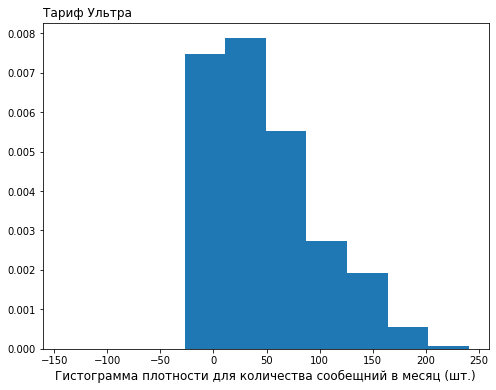

In [212]:
fig, ax = plt.subplots()
ax.hist(
    total_stats.loc[ total_stats['tariff'] == 'ultra']['messages_count'],
    range=(ultra_messages_mean-4*ultra_messages_std,ultra_messages_mean+4*ultra_messages_std),
    density=True
)
ax.set_title(
    "Тариф Ультра",
    fontsize=12,
    loc='left'
)
ax.set_xlabel("Гистограмма плотности для количества сообещний в месяц (шт.)", fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

In [213]:
total_stats.loc[ total_stats['tariff'] == 'ultra']['messages_count'].describe()

count               986.0
mean    49.31338742393509
std     47.80603962530092
min                   0.0
25%                   6.0
50%                  38.0
75%                 78.75
max                 224.0
Name: messages_count, dtype: float64

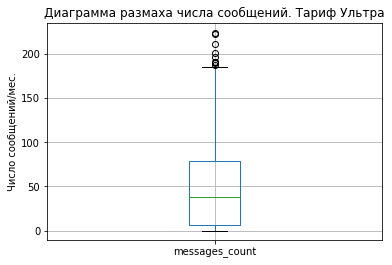

In [214]:
(
    total_stats.loc[ total_stats['tariff'] == 'ultra']
        .boxplot(column='messages_count')
        .set(
            title='Диаграмма размаха числа сообщений. Тариф Ультра',
            ylabel='Число сообщений/мес.',
        )
);

##### Интернет-трафик

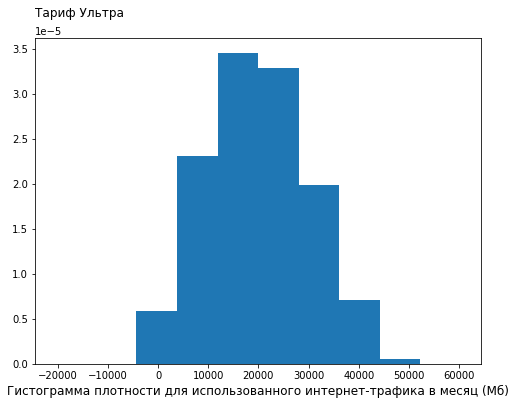

In [215]:
fig, ax = plt.subplots()
ax.hist(
    total_stats.loc[ total_stats['tariff'] == 'ultra']['mb_used'],
    range=(ultra_internet_traffic_mean - 4*ultra_internet_traffic_std,
           ultra_internet_traffic_mean + 4*ultra_internet_traffic_std),
    density=True
)
ax.set_title(
    "Тариф Ультра\n",
    fontsize=12,
    loc='left'
)
ax.set_xlabel("Гистограмма плотности для использованного интернет-трафика в месяц (Мб)", fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

In [216]:
total_stats.loc[ total_stats['tariff'] == 'ultra']['mb_used'].describe()

count                986.0
mean    19942.036511156188
std     10104.890125951337
min                    0.0
25%                12288.0
50%                19456.0
75%                27648.0
max                50176.0
Name: mb_used, dtype: float64

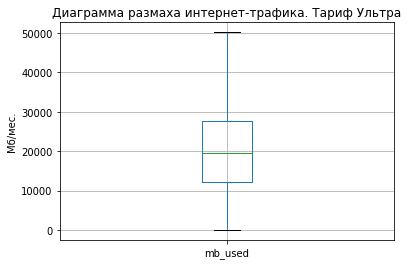

In [217]:
(
    total_stats.loc[ total_stats['tariff'] == 'ultra']
        .boxplot(column='mb_used')
        .set(
            title='Диаграмма размаха интернет-трафика. Тариф Ультра',
            ylabel='Мб/мес.',
        )
);

Распределения отдаленно напоминают своим видом нормальное (горкой ближе к центру). Учитывая малый размер выборки ожидать большого сходства с обычным графиком нормального распределения не приходится.

#### 3.2 Анализ показателей выборки тарифа Smart

##### Длительность звонков

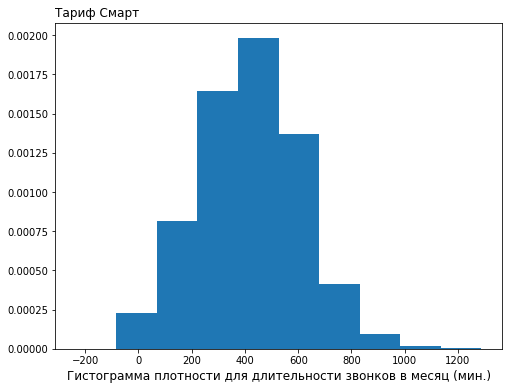

In [218]:
fig, ax = plt.subplots()
ax.hist(
    total_stats.loc[ total_stats['tariff'] == 'smart']['total_duration'],
    range=(smart_time_mean-4*smart_time_std,smart_time_mean+4*smart_time_std),
    density=True
)
ax.set_title(
    "Тариф Смарт",
    fontsize=12,
    loc='left'
)
ax.set_xlabel("Гистограмма плотности для длительности звонков в месяц (мин.)", fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

In [219]:
total_stats.loc[ total_stats['tariff'] == 'smart']['total_duration'].describe()

count              2230.0
mean     417.747533632287
std     190.4767540579285
min                   0.0
25%                 282.0
50%                 421.5
75%                 545.0
max                1435.0
Name: total_duration, dtype: float64

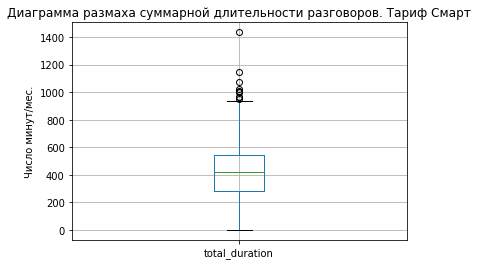

In [220]:
(
    total_stats.loc[ total_stats['tariff'] == 'smart']
        .boxplot(column='total_duration')
        .set(
            title='Диаграмма размаха суммарной длительности разговоров. Тариф Смарт',
            ylabel='Число минут/мес.'            
        )
);

##### Число сообщений

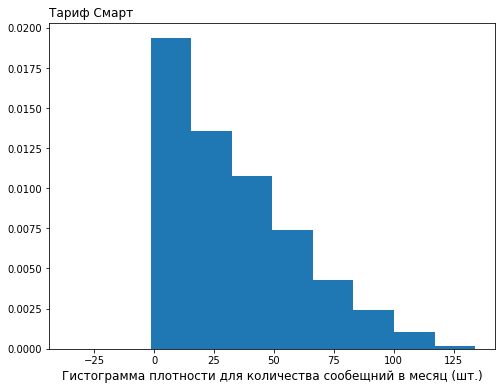

In [221]:
fig, ax = plt.subplots()
ax.hist(
    total_stats.loc[ total_stats['tariff'] == 'smart']['messages_count'],
    range=(smart_messages_mean - 3*smart_messages_std, smart_messages_mean + 3*smart_messages_std),
    density=True
)
ax.set_title(
    "Тариф Смарт",
    fontsize=12,
    loc='left'
)
ax.set_xlabel("Гистограмма плотности для количества сообещний в месяц (шт.)", fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

In [222]:
total_stats.loc[ total_stats['tariff'] == 'smart']['messages_count'].describe()

count               2230.0
mean     33.36905829596412
std     28.230395954185852
min                    0.0
25%                   10.0
50%                   28.0
75%                   51.0
max                  143.0
Name: messages_count, dtype: float64

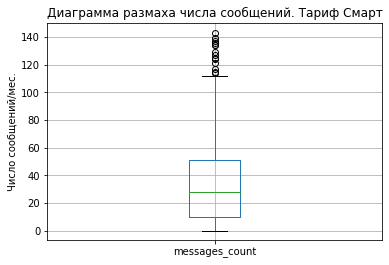

In [223]:
(
    total_stats.loc[ total_stats['tariff'] == 'smart']
        .boxplot(column='messages_count')
        .set(
            title='Диаграмма размаха числа сообщений. Тариф Смарт',
            ylabel='Число сообщений/мес.'
        )
);

##### Интернет-трафик

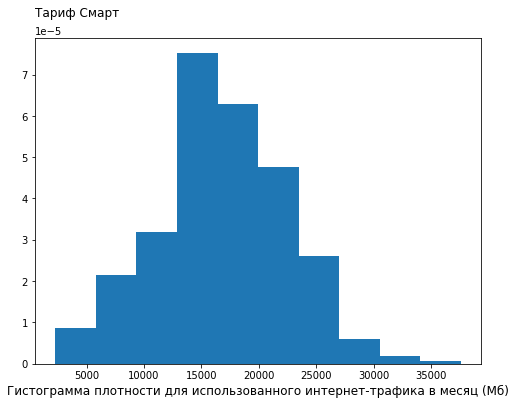

In [224]:
fig, ax = plt.subplots()
ax.hist(
    total_stats.loc[ total_stats['tariff'] == 'smart']['mb_used'],
    range=(
        smart_internet_traffic_mean - 3*smart_internet_traffic_std, 
        smart_internet_traffic_mean + 3*smart_internet_traffic_std),
    density=True
)
ax.set_title(
    "Тариф Смарт\n",
    fontsize=12,
    loc='left'
)
ax.set_xlabel("Гистограмма плотности для использованного интернет-трафика в месяц (Мб)", fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

In [225]:
total_stats.loc[ total_stats['tariff'] == 'smart']['mb_used'].describe()

count               2230.0
mean    16713.241255605382
std      5894.314519107293
min                    0.0
25%                13312.0
50%                17408.0
75%                20480.0
max                38912.0
Name: mb_used, dtype: float64

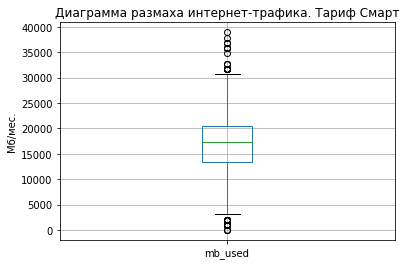

In [226]:
(
    total_stats.loc[ total_stats['tariff'] == 'smart']
        .boxplot(column='mb_used')
        .set(
            title='Диаграмма размаха интернет-трафика. Тариф Смарт',
            ylabel='Мб/мес.',
        )
);

И для длительности звонков и для числа сообщений и для интернет-трафика наблюдаются графики схожие с нормальным распределением<BR>
(которые при этом могут визуально существенно от него отличаться в зависимости от того какая получилась выборка. Это связано с небольшим размером выборок)

При этом можно наблюдать что дисперсия (и среднеквадратичное отклонение) для тарифа Ultra существенно меньше чем для тарифа Smart.

Для тарифа Ultra пользователям в среднем требуется <BR>
от 264 до 668 минут разговора (медиана 477, среднее 489)
от 35 до 71 сообщений (медиана 40, среднее 56)<BR>
от 8 до 21 Гб интернет-трафика (медиана 11 Гб, среднее 15 Гб)<BR>
<BR>
Для тарифа Smart пользователям в среднем требуется <BR>
от 356 до 561 минут разговора (медиана 479, среднее 467)<BR>
от 22 до 57 сообщений (медиана 37, среднее 40)<BR>
от 13 до 21 Гб интернет-трафика (медиана 17 Гб, среднее 17 Гб)<BR>
<BR>
Любопытно что при более ёмком тарифе Ultra пользователи тарифа Smart используют больше интернет-трафика. А средняя длительность звонков и число сообщений имеют маленькие отличия.


#### 3.3 Сравнение пользоватей

Кто пользуется тарифами?

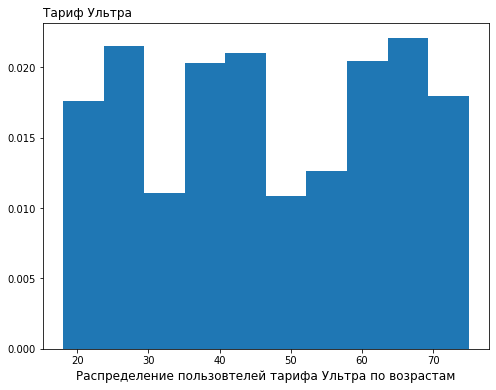

In [227]:
fig, ax = plt.subplots()
ax.hist(
    total_stats.loc[ total_stats['tariff'] == 'ultra']['age'],
    density=True
)
ax.set_title(
    "Тариф Ультра",
    fontsize=12,
    loc='left'
)
ax.set_xlabel("Распределение пользовтелей тарифа Ультра по возрастам", fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

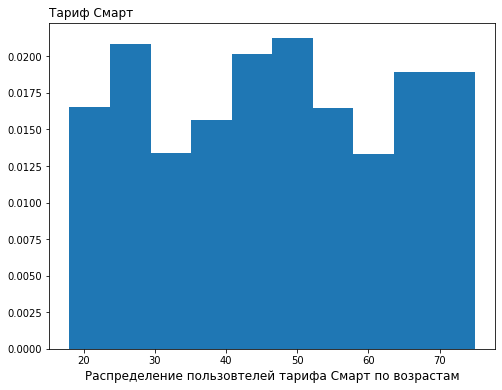

In [228]:
fig, ax = plt.subplots()
ax.hist(
    total_stats.loc[ total_stats['tariff'] == 'smart']['age'],
    density=True
)
ax.set_title(
    "Тариф Смарт",
    fontsize=12,
    loc='left'
)
ax.set_xlabel("Распределение пользовтелей тарифа Смарт по возрастам", fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

In [229]:
total_stats.loc[ total_stats['tariff'] == 'ultra']['age'].describe()


count                986.0
mean     46.83874239350913
std     17.099807344198307
min                   18.0
25%                   30.0
50%                   45.0
75%                   63.0
max                   75.0
Name: age, dtype: float64

In [230]:
total_stats.loc[ total_stats['tariff'] == 'smart']['age'].describe()

count               2230.0
mean    46.557847533632284
std      16.34986534365247
min                   18.0
25%                   32.0
50%                   47.0
75%                   62.0
max                   75.0
Name: age, dtype: float64

In [231]:
# Подчсет числа пользователей разных тарифов для Москвы и вне Москвы
ultra_moscow_count = len(total_stats.loc[ (total_stats['tariff'] == 'ultra') & (total_stats['city'] == 'Москва')] )
smart_moscow_count = len(total_stats.loc[ (total_stats['tariff'] == 'smart') & (total_stats['city'] == 'Москва')] )
total_moscow_count = len(total_stats.loc[total_stats['city'] == 'Москва'] )
ultra_ratio_moscow = ultra_moscow_count / total_moscow_count
smart_ratio_moscow = smart_moscow_count / total_moscow_count

# Не Москва
ultra_nonmoscow_count = len(total_stats.loc[ (total_stats['tariff'] == 'ultra') & (total_stats['city'] != 'Москва')] )
smart_nonmoscow_count = len(total_stats.loc[ (total_stats['tariff'] == 'smart') & (total_stats['city'] != 'Москва')] )
total_nonmoscow_count = len(total_stats.loc[total_stats['city'] != 'Москва'] )
ultra_ratio_nonmoscow = ultra_nonmoscow_count / total_nonmoscow_count
smart_ratio_nonmoscow = smart_nonmoscow_count / total_nonmoscow_count

In [232]:
print( "Москва:")
print(f"Пользователей Ultra: {ultra_moscow_count} ({ultra_ratio_moscow:0.2%})")
print(f"Пользователей Smart: {smart_moscow_count} ({smart_ratio_moscow:0.2%})")

print( "Не Москва:")
print(f"Пользователей Ultra: {ultra_nonmoscow_count} ({ultra_ratio_nonmoscow:0.2%})")
print(f"Пользователей Smart: {smart_nonmoscow_count} ({smart_ratio_nonmoscow:0.2%})")

Москва:
Пользователей Ultra: 225 (36.82%)
Пользователей Smart: 386 (63.18%)
Не Москва:
Пользователей Ultra: 761 (29.21%)
Пользователей Smart: 1844 (70.79%)


In [233]:
total_stats.loc[ (total_stats['tariff'] == 'ultra') ]['total_duration'].describe()

count               986.0
mean    526.0892494929006
std     317.8875485911392
min                   0.0
25%                 282.5
50%                 518.0
75%                751.75
max                1673.0
Name: total_duration, dtype: float64

In [234]:
total_stats.loc[ (total_stats['tariff'] == 'smart') ]['total_duration'].describe()

count              2230.0
mean     417.747533632287
std     190.4767540579285
min                   0.0
25%                 282.0
50%                 421.5
75%                 545.0
max                1435.0
Name: total_duration, dtype: float64

In [235]:
total_stats.loc[ (total_stats['tariff'] == 'ultra') ]['messages_count'].describe()

count               986.0
mean    49.31338742393509
std     47.80603962530092
min                   0.0
25%                   6.0
50%                  38.0
75%                 78.75
max                 224.0
Name: messages_count, dtype: float64

In [236]:
total_stats.loc[ (total_stats['tariff'] == 'smart') ]['messages_count'].describe()

count               2230.0
mean     33.36905829596412
std     28.230395954185852
min                    0.0
25%                   10.0
50%                   28.0
75%                   51.0
max                  143.0
Name: messages_count, dtype: float64

In [237]:
total_stats.loc[ (total_stats['tariff'] == 'ultra') ]['mb_used'].describe()

count                986.0
mean    19942.036511156188
std     10104.890125951337
min                    0.0
25%                12288.0
50%                19456.0
75%                27648.0
max                50176.0
Name: mb_used, dtype: float64

In [238]:
total_stats.loc[ (total_stats['tariff'] == 'smart') ]['mb_used'].describe()

count               2230.0
mean    16713.241255605382
std      5894.314519107293
min                    0.0
25%                13312.0
50%                17408.0
75%                20480.0
max                38912.0
Name: mb_used, dtype: float64

### Шаг 4. Проверка гипотез

#### 4.1 Гипотеза: Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается.

Нулевая гипотеза (H<sub>0</sub>) при поставленной задаче звучит так:<BR>
Средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается.<BR>
Соответственно, альтернативная односторонняя гипотеза (H<sub>1</sub>): <BR>
Средняя выручка пользователей тарифа "Ультра" больше средней выручки тарифа "Смарт".<BR>
Мы используем одностороннюю альтернативную гипотезу, так как перед проектом поставлена задача выяснить,<BR>
какой тариф лучше, а не просто выяснить есть ли разница между тарифами.

Установим критический уровень значимости в 5%, так как нет требовний к особо точной оценке

In [239]:
alpha= 0.05 

Проводим Т-тест и смотрим какие у нас получились средние значения выручки для наших выборок

In [240]:
compare_data = st.ttest_ind(  total_stats.loc[ total_stats['tariff'] == 'ultra' ]['period_income'],
                              total_stats.loc[ total_stats['tariff'] == 'smart' ]['period_income'],
                              equal_var = False 
                           ) 
df_ultra_sample_mean = total_stats.loc[ total_stats['tariff'] == 'ultra' ]['period_income'].mean()
df_smart_sample_mean = total_stats.loc[ total_stats['tariff'] == 'smart' ]['period_income'].mean()

print(f"Среднее значение выручки для тарифа Ultra = {df_ultra_sample_mean:.2f}")
print(f"Среднее значение выручки для тарифа Smart = {df_smart_sample_mean:.2f}")

Среднее значение выручки для тарифа Ultra = 2070.03
Среднее значение выручки для тарифа Smart = 1289.64


Проверяем, можем ли мы отвергнуть нулевую гипотезу. Так как альтернативная гипотеза односторонняя - берём половину от p.value.

In [263]:
if (    compare_data.pvalue/2 < alpha    ):
    print(f'Нулевая гипотеза отвергается: Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается, pvalue({compare_data.pvalue}) < alpha({alpha})')
else :
    print(f'Нулевая гипотеза не отвергается: Средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается, pvalue({compare_data.pvalue}) >= alpha({alpha})')

Нулевая гипотеза отвергается: Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается, pvalue(1.927011394420941e-250) < alpha(0.05)


In [262]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


In [243]:
screens = pd.Series([4, 2, 4, 5, 5, 4, 2, 3, 3, 5
                     , 2, 5, 2, 2, 2, 3, 3, 4, 8, 3, 4, 3, 5,
                     5, 4, 2, 5, 2, 3, 7, 5, 5, 6,  5, 3, 4, 3, 6, 3, 4, 
                     4, 3, 5, 4, 4, 8, 4, 7, 4, 5, 5, 3, 4, 6, 7, 2, 3, 6, 
                     5, 6, 4, 4, 3, 4, 6, 4, 4, 6, 2, 6, 5, 3, 3, 3, 4, 5, 3, 
                     5, 5, 4, 3, 3, 3, 1, 5, 4, 3, 4, 6, 3, 1, 3, 2, 7, 3, 6, 6, 6, 5, 5])

prev_screens_value = 4.867

alpha = .05 # уровень статистической значимости

results = st.ttest_1samp(
    screens, 
    prev_screens_value)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только тогда, когда выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (screens.mean() < prev_screens_value):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение: 1.3358596895543794e-06
Отвергаем нулевую гипотезу


#### 4.2 Гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Проверим есть ли разница в выручке между Москвой и другими регионами.

In [244]:
moscow = pd.concat(
    [
       total_stats.loc[ total_stats['city'] == 'Москва']
    ],
    ignore_index=True
)

nonmoscow = pd.concat(
    [
       total_stats.loc[ total_stats['city'] != 'Москва']
    ],
    ignore_index=True    
)

In [245]:
# Особых требований к точности не предъявлено, выборка маленькая, значит будем оценивать грубо,
# взяв 5% в качестве критического уровня значимости
alpha = 0.05 

In [246]:
# Считаем среднее, дисперсию, отклонение
moscow_sample_mean = moscow['period_income'].mean()
moscow_sample_var  = np.var( moscow['period_income'], ddof=1)
moscow_sample_std  = np.std( moscow['period_income'], ddof=1)

nonmoscow_sample_mean = nonmoscow['period_income'].mean()
nonmoscow_sample_var  = np.var( nonmoscow['period_income'], ddof=1)
nonmoscow_sample_std  = np.std( nonmoscow['period_income'], ddof=1)

print( 'Москва:')
print(f"Средний доход с выборки: {moscow_sample_mean:.02f}")
print(f"Дисперсия выборки: {moscow_sample_var:.02f}")
print(f"Среднее отклонение для выборки: {moscow_sample_std:.02f}")
print()
print( 'Другие регионы:')
print(f"Средний доход с выборки: {nonmoscow_sample_mean:.02f}")
print(f"Дисперсия выборки: {nonmoscow_sample_var:.02f}")
print(f"Среднее отклонение для выборки: {nonmoscow_sample_std:.02f}")

Москва:
Средний доход с выборки: 1546.71
Дисперсия выборки: 565636.47
Среднее отклонение для выборки: 752.09

Другие регионы:
Средний доход с выборки: 1524.73
Дисперсия выборки: 654069.57
Среднее отклонение для выборки: 808.75


Нулевая гипотеза (H<sub>0</sub>): средняя выручка пользователей из Москвы не отличается от средней выручки от других регионов.<BR>
Альтернативная гипотеза (H<sub>1</sub>): средняя выручка пользователей из Москвы и других регионов различаются

In [247]:
ttest_results = st.ttest_ind(
    moscow['period_income'],
    nonmoscow['period_income'],
    equal_var = False
)

Проверка нулевой гипотезы (о равенстве выручки для Москвы и других регионов):

In [248]:
if ttest_results.pvalue < alpha:
    print(f"pvalue({ttest_results.pvalue}) < alpha({ alpha})")
    print("Отвергаем нулевую гипотезу. Выручка для Москвы отличается от выручки для других регионов")
else:
    print(f"pvalue({ttest_results.pvalue}) >= alpha({alpha})")
    print("Не отвергаем нулевую гипотезу. Выручка для Москвы не отличается от выручки для других регионов")

pvalue(0.5216952110000279) >= alpha(0.05)
Не отвергаем нулевую гипотезу. Выручка для Москвы не отличается от выручки для других регионов


Итак, нет оснований считать что выручка между Москвой и регионами имеет существенное различие. Она выглядит сопостовимой.

### Шаг 5. Общий вывод

Обоими тарифами пользуются те же возрастные группы, с практически одинаковым медианным и средним значением.<BR>
Смарт: преимущественно пользователи с 32 до 62 лет, в среднем 46-47 лет<BR>
Ультра: преимущественно пользователи с 30 до 63 лет, в среднем 45-46 лет<BR>
<BR>
Процентное соотношение пользователей обоих тарифов<BR>
Москва:<BR>
Пользователей Ultra: 225 (36.82%)<BR>
Пользователей Smart: 386 (63.18%)<BR>
Не Москва:<BR>
Пользователей Ultra: 761 (29.21%)<BR>
Пользователей Smart: 1844 (70.79%)<BR>


Использование звонков, сообщений и интернет-трафика:<BR>
Звонки. <BR>
Ultra от 282.5 до 751.75 минут в месяц. Среднее время 526, медианное 518, (в тариф включено 3000) <BR>
Smart от 282 до 545 минут в месяц. Среднее время 417, медианное 421. (в тариф включено 500)<BR>
Сообщения<BR>
Ultra от 6 до 79 смс в месяц. Среднее 49, медианное 38. (в тариф включено 1000)<BR>
Smart от 10 до 51 смс в месяц. Среднее 33, медианное 28.(в тариф включено 50)<BR>
Интернет-трафик<BR>
Ultra от 12 гб до 27 гб. в месяц. Среднее 19, медианное 19 (в тариф включено 30) <BR>
Smart от 13 гб до 20 гб. в месяц. Среднее 16, медианное 17 (в тариф включено 15).<BR>

На основе предоставленных данных были сделаны проверки гепотез о различии средних выручек тарифов "Ультра" и "Смарт", а также о различии средних выручек для пользователей из Москвы и други регионов.
Проверка выборок показала что:

Если же говорить про гипотезу о различии выручки для Москвы и других регионов, то проверка показала очень схожую выручку. Несмотря на то что тариф Ультра в Москве несколько популярнее чем в других городах,<BR>
тем не менее совокупный доход в Москве сопостовим с доходом в других регионах.

Среднее значение выручки для тарифа Ultra = 2070.03<BR>
Среднее значение выручки для тарифа Smart = 1289.64<BR>
<BR>
Статистическая проверка показала что выручка с этих тарифов существенно отличается. И тариф Ультра является более выгодным для опреатора связи, так как приносит большую выручку
    

## Бонус

In [249]:
# check
total_stats['period_income'].sum()

4916951.0

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

In [259]:
revenue = total_stats.copy()

In [260]:
revenue.columns

Index(['user_id', 'period', 'calls_count', 'total_duration', 'messages_count',
       'mb_used', 'gb_used', 'age', 'churn_date', 'city', 'first_name',
       'last_name', 'reg_date', 'tariff', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
       'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff_name',
       'time_overpayed', 'messages_overpayed', 'internet_overpayed', 'overpay',
       'period_income'],
      dtype='object')

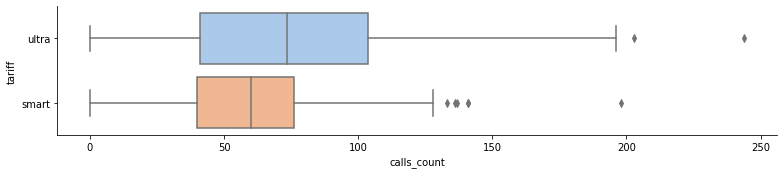

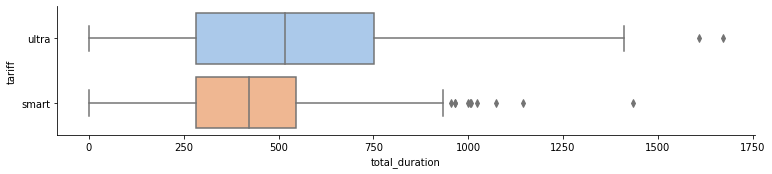

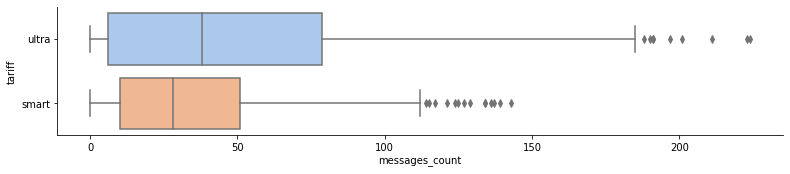

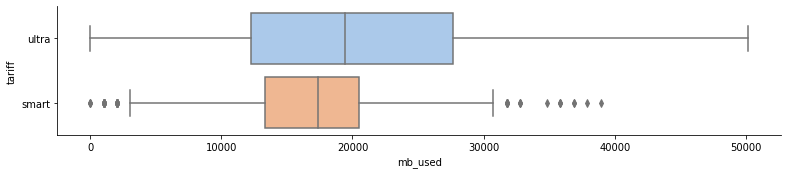

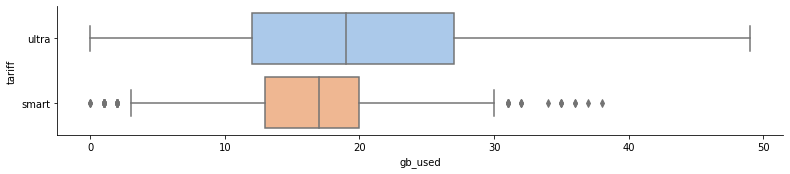

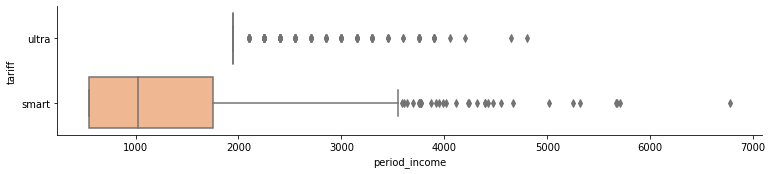

In [253]:
for column in ['calls_count', 'total_duration', 'messages_count',
       'mb_used', 'gb_used', 'period_income']:    
    g = sns.catplot(y='tariff', x=column, kind="box", data= revenue, orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)

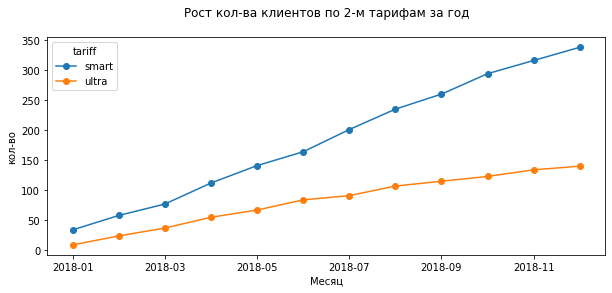

In [254]:
(revenue
 .pivot_table(index='tariff', columns='period', values='user_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Рост кол-ва клиентов по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('кол-во');

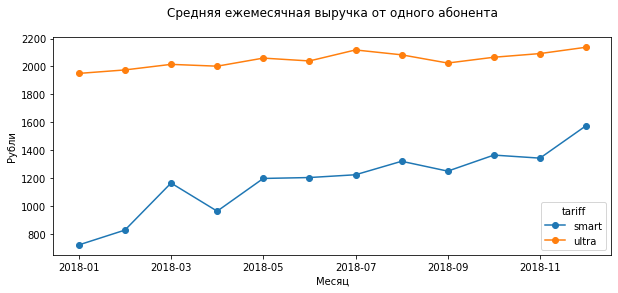

In [255]:
(revenue
 .pivot_table(index='tariff', columns='period', values='period_income', aggfunc='mean')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Средняя ежемесячная выручка от одного абонента'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

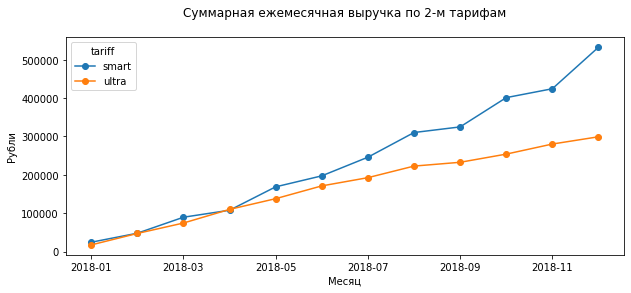

In [256]:
(revenue
 .pivot_table(index='tariff', columns='period', values='period_income', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Суммарная ежемесячная выручка по 2-м тарифам'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

In [257]:
# на скорую руку
df_users = pd.read_csv('/datasets/users.csv')

print ('Кол-во клентов покинувших компанию за год', df_users.churn_date.notna().sum())

print ('Кол-во клентов покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах',
       df_users.query('churn_date > "2018-09-25"').churn_date.notna().sum()
      )
print ('%  от общего кол-ва всех клиентов, покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах',
    (df_users.query('churn_date > "2018-09-25"').churn_date.notna().sum()/df_users.churn_date.notna().sum()*100).round(1)
)

print ('Распределение оттока клиентов на тарифах за посл. 4 мес. 2018 г.')
df_users.query('churn_date > "2018-09-25"').groupby('tariff')['churn_date'].count().to_frame()

Кол-во клентов покинувших компанию за год 38
Кол-во клентов покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах 35
%  от общего кол-ва всех клиентов, покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах 92.1
Распределение оттока клиентов на тарифах за посл. 4 мес. 2018 г.


,churn_date
tariff,
smart,22
ultra,13
